<a href="https://colab.research.google.com/github/evansemet/Jane-Street-Solutions/blob/main/2019_08_Knight_Moves_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is all done except there probably is a way to run this in Z3 wihtout the for loop trying all number of moves >= 37 until it fails. Additionally there is no check to guarentee that the product of the empty regions is minimized. I need to come back and address this later.

In [ ]:
!pip install z3-solver
from bs4 import BeautifulSoup
from IPython.display import Markdown, display, HTML, Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from scipy.ndimage import measurements
import seaborn as sns
import time
from z3 import *

### Puzzle as published 
https://www.janestreet.com/puzzles/knight-moves-3-index/

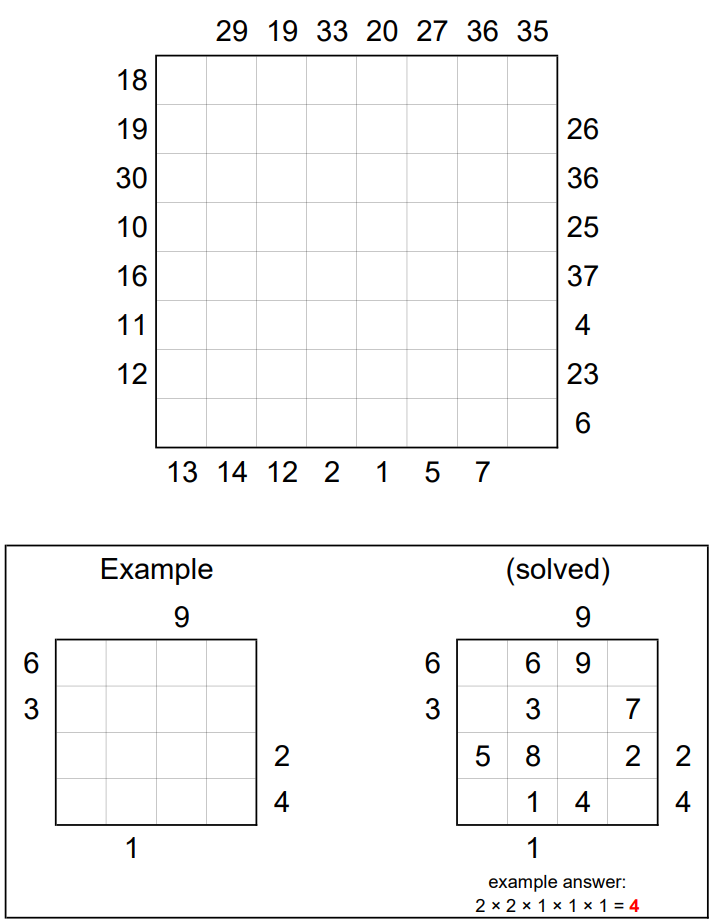

In [ ]:
# the problem to solve
url = 'https://www.janestreet.com/puzzles/knight-moves-3-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published \n'+ url))
display(Image('https://www.janestreet.com/puzzles/20190805_knight_moves_3.png', width=300))
HTML(str(soup.find_all('div', {'class' :'inner-wrapper'})[1]))

In [ ]:
# values given
top = np.array([0,29,19,33,20,27,36,35], dtype=int)
rhs = np.array([0,26,36,25,37,4,23,6], dtype=int)
bot = np.array([13,14,12,2,1,5,7,0], dtype=int)
lhs = np.array([18,19,30,10,16,11,12,0], dtype=int)

In [ ]:
# helper functions
# finds the product of empty regions
def areas(grid):
  labels, num = measurements.label(grid < 1)
  areas = measurements.sum(grid < 1, labels, index=range(1, num + 1))
  return  int(np.prod(areas))

# defines how a knight can move
def moves(i, j, N):
    moves = [(2, 1), (1, 2), (-1, 2), (-2, 1), (-2, -1), (-1, -2), (1, -2), (2, -1)]
    return [(i + x, j + y) for x, y in moves if i + x >= 0 and i + x < N and j + y >= 0 and j + y < N]

In [60]:
# solve method using Z3
def solve(HIGHEST):
  print(f"Solving for {HIGHEST} moves...")
  start = time.time()
  X = np.array(IntVector("x", 8 ** 2), dtype=object).reshape((8, 8))
  # faster than using just s = Solver() for this problem
  s = Tactic("qffd").solver()
  
  # every value needs to be greater than 0 but it is unclear how high it can go also one instance of every number
  s += [And(val >= 0, val <= HIGHEST) for pos, val in np.ndenumerate(X)]
  s += [PbEq([(val == n, 1) for (r, c), val in np.ndenumerate(X)], 1) for n in range(1, HIGHEST + 1)]
  # moves in the pattern of a knight
  s += [Or(val == 0, val == 1, PbEq([(X[k][l] == val - 1, 1) for k, l in moves(i, j, 8)], 1)) for (i, j), val in np.ndenumerate(X)]

  # this chunk isn't needed for the code to work, but it makes it run faster
  # the corners are forced
  s += [And(X[0][0] == 18, X[0][7] == 35, X[7][0] == 13, X[7][7] == 6)]
  # values on both a top or bottom and a lhs or rhs are also forced along with respective zeros
  s += [And(X[1][0] == 0, X[1][1] == 0, X[1][2] == 19, X[0][2] == 0)]
  s += [And(X[0][6] == 0, X[1][6] == 0, X[2][6] == 36, X[2][7] == 0)]
  s += [And(X[6][0] == 0, X[6][1] == 0, X[6][2] == 12, X[7][2] == 0)]

  # constraint for value when looking in - don't do for corners since those are forced
  # uncomment if statements if get rid of the unecessary block above and also chance range to 8 instead of 1, 7
  for n in range(1, 7):
    #if top[n] > 0:
      s += If(X[0][n] == 0, If(X[1][n] == 0, If(X[2][n] == 0, If(X[3][n] == 0, If(X[4][n] == 0, If(X[5][n] == 0, 
              X[6][n] == int(top[n]), X[5][n] == int(top[n])), X[4][n] == int(top[n])), X[3][n] == int(top[n])), 
                X[2][n] == int(top[n])), X[1][n] == int(top[n])), X[0][n] == int(top[n]))
    
    #if lhs[n] > 0:
      s += If(X[n][0] == 0, If(X[n][1] == 0, If(X[n][2] == 0, If(X[n][3] == 0, If(X[n][4] == 0, If(X[n][5] == 0, 
              X[n][6] == int(lhs[n]), X[n][5] == int(lhs[n])), X[n][4] == int(lhs[n])), X[n][3] == int(lhs[n])), 
                X[n][2] == int(lhs[n])), X[n][1] == int(lhs[n])), X[n][0] == int(lhs[n]))
    
    #if bot[n] > 0:
      s += If(X[7][n] == 0, If(X[6][n] == 0, If(X[5][n] == 0, If(X[4][n] == 0, If(X[3][n] == 0, If(X[2][n] == 0, 
              X[1][n] == int(bot[n]), X[2][n] == int(bot[n])), X[3][n] == int(bot[n])), X[4][n] == int(bot[n])), 
                X[5][n] == int(bot[n])), X[6][n] == int(bot[n])), X[7][n] == int(bot[n]))

    #if rhs[n] > 0:
      s += If(X[n][7] == 0, If(X[n][6] == 0, If(X[n][5] == 0, If(X[n][4] == 0, If(X[n][3] == 0, If(X[n][2] == 0, 
              X[n][1] == int(rhs[n]), X[n][2] == int(rhs[n])), X[n][3] == int(rhs[n])), X[n][4] == int(rhs[n])), 
                X[n][5] == int(rhs[n])), X[n][6] == int(rhs[n])), X[n][7] == int(rhs[n]))

  while s.check() == sat:
    m = s.model()
    evalu = np.vectorize(lambda x: m.evaluate(x).as_long())
    r = evalu(X)
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax = sns.heatmap(r==0, annot=r, cbar=False, cmap="tab20", linecolor='k', linewidth=2, annot_kws={"fontsize":14})
    ax.axis("off")
    val = areas(r)
    print(f"Product of regions is {val}.")
    print(f"Solved in {time.time() - start} seconds.")
    return True
  else:
    print(f"Failed in {time.time() - start} seconds.")
    return False

Solving for 37 moves...
Product of regions is 1440.
Solved in 0.7351913452148438 seconds.

Solving for 38 moves...
Product of regions is 360.
Solved in 0.7203176021575928 seconds.

Solving for 39 moves...
Product of regions is 1728.
Solved in 0.7155478000640869 seconds.

Solving for 40 moves...
Product of regions is 1440.
Solved in 0.6752336025238037 seconds.

Solving for 41 moves...
Product of regions is 672.
Solved in 0.7214450836181641 seconds.

Solving for 42 moves...
Product of regions is 504.
Solved in 0.7435007095336914 seconds.

Solving for 43 moves...
Product of regions is 432.
Solved in 0.9242138862609863 seconds.

Solving for 44 moves...
Product of regions is 144.
Solved in 0.7549948692321777 seconds.

Solving for 45 moves...
Product of regions is 288.
Solved in 0.8329229354858398 seconds.

Solving for 46 moves...
Failed in 0.7765498161315918 seconds.


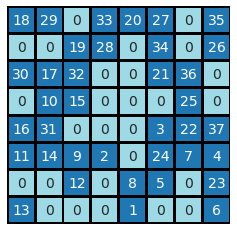

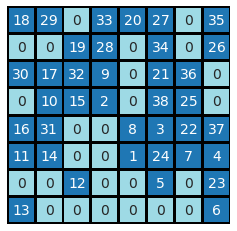

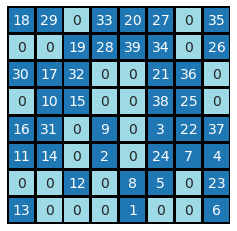

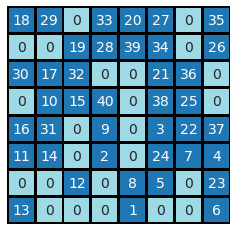

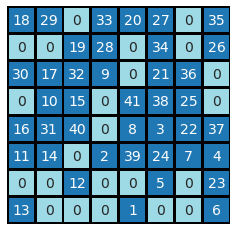

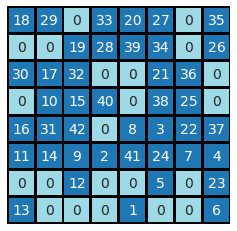

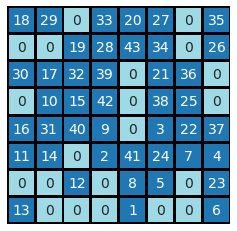

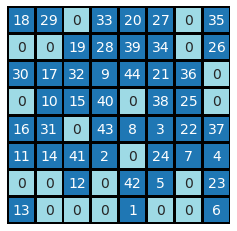

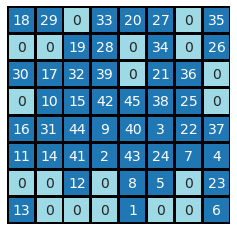

In [61]:
for i in range(37, 65):
  if not solve(i):
    break
  print()